# LSQT-Jupyter

## 1. Introduction

* `LSQT-Jupyter` is a Jupyter notebook demonstrating some practical apects of the linear-scaling quantum transport methods reviewd in Ref. [1].
* The programming language chosen is `Python 3`.
* We will refer to Ref. [1] frequently for the relevant theoretical backgounds.
* This code is only suitable for leanring the methods. For high performance computing, check the `GPUQT` code I wrote: https://github.com/brucefan1983/gpuqt
* This code only considers square lattice with Anderson disoder as the model system. For more general simulations, again check the `GPUQT` code.
* For fans of `Matlab`, check the `lsqt-matlab` code I wrote: https://github.com/brucefan1983/lsqt-matlab

[1] Zheyong Fan, Jose Hugo Garcia, Aron W Cummings, Jose-Eduardo Barrios, Michel Panhans, Ari Harju, Frank Ortmann, and Stephan Roche, Linear Scaling Quantum Transport Methodologies, submitted to Reviews of Modern Physics. https://arxiv.org/abs/1811.07387

## 2. Unit system (We are working in 2D)
* Basic units:
 * Reduced Planck constant $\hbar$ = 1
 * Elementary charge $e$ = 1
 * Energy unit $\gamma=1$ is hopping integral
 * Length unit $a=1$ is the lattice constant
* Derived units:
 * Time: $\hbar/\gamma$
 * Densit of states (DOS) in 2D: $1/\gamma/a^2$
 * Velocity autocorrelation (VAC): $a^2\gamma^2/\hbar^2$
 * Mean square displacement (MSD): $a^2$
 * Electrical conductivity in 2D: $e^2/\hbar$
 * Electrical conductance: $e^2/\hbar$

## 3. Import the needed Python packages

In [1]:
import numpy as np              # used frequently
import matplotlib as mpl        # do we need this?
import matplotlib.pyplot as plt # used for plotting
from scipy import sparse        # crucial for performance
from scipy import integrate     # do we need this?
from scipy import special       # for Bessel function

## 4. Construct the tight-binding model
1. We consdier the nearest-neighbor tight-bindng model defined on a square lattice with lattice constant $a$ and dimensions $N=N_x\times N_y$.
2. The Hamiltonian can be written as
$$
\hat{H} = \sum_{ij} (-\gamma) c_i^{\dagger} c_j + \sum_i U_i c_i^{\dagger} c_i,
$$
where $-\gamma$ is the hopping integral and $U_i$ are the on-site potentials. The on-site potentials are uniformly distributed in an interval $[-W/2, W/2]$, where $W$ is the Anderson disorder strength. For simplicity, we consider open boundary conditions in the $y$ direction and study the transorpt in the $x$ direction.

### 4.1 Define an indexing scheme
1. The purpose is to map th 2D indices in the lattice into 1D indices
2. The 1D indices will be used for the Hamiltionian, velcoity operator, and various vectors.
3. This only requires a simple function shown below:

In [2]:
def find_index(nx, ny, Ny):
    """
    Get a 1D index from a 2D index
    Args:
        nx (int): x-index of a site
        ny (int): y-index of the same site
    Returns:
        index (int): 1D index for (nx, ny)
    """
    index = nx * Ny + ny
    return index

### 4.2. Define the function for creating the sparse Hamiltonian and velocity operator
1. We consider square lattice with $N_x \times N_y$ lattice sites.
2. Use periodic boundary conditions in the $x$ direction.
3. Use open boundary conditions in the $y$ direction.
4. Assume the transport is in the $x$ direction.
5. All the hoppings integral $\gamma=1$ defines the energy units.
6. The lattices constant $a=1$ defines the length units.
7. Anderson diorder strength is $W$, which means that random on-site potentials are uniformly chosen from $[-W/2, W/2]$. $W$ is in units of $\gamma$.

In [3]:
def find_H(Nx, Ny, W):
    """
    Construct the sparse Hamiltonian and velocity operator
    Args:
        Nx (int): number of lattice points in the x direction
        Ny (int): number of lattice points in the y direction
        W (real): Anderson disorder strength
    Returns:
        H (sparse.csr_matrix): The sparse Hamiltonian
        V (sparse.csr_matrix): The sparse velocity operator
    """
    N = Nx * Ny; # total number of sites
    row_H = np.zeros(N * 4 - Nx * 2) # the row indices for H
    col_H = np.zeros(N * 4 - Nx * 2) # the column indices for H
    Hij = -np.ones(N * 4 - Nx * 2, complex) # nonzero Hamiltonian elements
    row_V = np.zeros(N * 2) # row indices for V
    col_V = np.zeros(N * 2) # column indices for V
    Vij = np.zeros(N * 2, complex) # nonzero velocity matrix elements
    row_U = np.arange(0, N) # row and column indices for U
    Uij = np.random.uniform(-W * 0.5, W * 0.5, N) # on-site potentials
    count_H = 0 # number of nonzero H elements
    count_V = 0 # number of nonzero V elements
    for nx in range(Nx):
        for ny in range(Ny):
            # (0) # get the index of the center site
            index_center = find_index(nx, ny, Ny)
            # (1) consider the left neighbor (periodic boundary)
            index_left = find_index((nx - 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_left
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_left
            Vij[count_V] = 1j
            count_V += 1
            # (2) consider the right neighbor (periodic boundary)
            index_right = find_index((nx + 1) % Nx, ny, Ny)
            row_H[count_H] = index_center
            col_H[count_H] = index_right
            count_H += 1
            row_V[count_V] = index_center
            col_V[count_V] = index_right
            Vij[count_V] = -1j
            count_V += 1
            # (3) consider the upper neighbor (open boundary)
            if ny < Ny - 1:
                index_up = find_index(nx, (ny + 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_up
                count_H += 1
            # (4) consider the down neighbor (open boundary)
            if ny > 0:
                index_down = find_index(nx, (ny - 1), Ny)
                row_H[count_H] = index_center
                col_H[count_H] = index_down
                count_H += 1
    H = sparse.csr_matrix((Hij, (row_H, col_H)), shape = (N, N))
    U = sparse.csr_matrix((Uij, (row_U, row_U)), shape = (N, N))
    H = H + U
    V = sparse.csr_matrix((Vij, (row_V, col_V)), shape = (N, N))
    return (H, V)

### 4.3. Check the `find_H` function and visualize the sparse matrices
1. Try $N_x = N_y = 4$ and print H and V. One can check (with pencil and paper) that the results are correct.
2. Check the pattern of H: each row (or column) only has 4 or 5  nonzero elements.
3. Check the pattern of V: each row (or column) only has 2 nonzero elements.

In [4]:
H, V = find_H(4, 4, 1)
print(H)
print("==========================================")
print(V)

  (0, 0)	(-0.266801358582+0j)
  (0, 1)	(-1+0j)
  (0, 4)	(-1+0j)
  (0, 12)	(-1+0j)
  (1, 0)	(-1+0j)
  (1, 1)	(-0.0645718576443+0j)
  (1, 2)	(-1+0j)
  (1, 5)	(-1+0j)
  (1, 13)	(-1+0j)
  (2, 1)	(-1+0j)
  (2, 2)	(0.350173945498+0j)
  (2, 3)	(-1+0j)
  (2, 6)	(-1+0j)
  (2, 14)	(-1+0j)
  (3, 2)	(-1+0j)
  (3, 3)	(0.104140856952+0j)
  (3, 7)	(-1+0j)
  (3, 15)	(-1+0j)
  (4, 0)	(-1+0j)
  (4, 4)	(0.0962817411791+0j)
  (4, 5)	(-1+0j)
  (4, 8)	(-1+0j)
  (5, 1)	(-1+0j)
  (5, 4)	(-1+0j)
  (5, 5)	(0.341871450555+0j)
  :	:
  (10, 10)	(-0.0818245069255+0j)
  (10, 11)	(-1+0j)
  (10, 14)	(-1+0j)
  (11, 7)	(-1+0j)
  (11, 10)	(-1+0j)
  (11, 11)	(0.42466268555+0j)
  (11, 15)	(-1+0j)
  (12, 0)	(-1+0j)
  (12, 8)	(-1+0j)
  (12, 12)	(0.307140048064+0j)
  (12, 13)	(-1+0j)
  (13, 1)	(-1+0j)
  (13, 9)	(-1+0j)
  (13, 12)	(-1+0j)
  (13, 13)	(-0.208325707667+0j)
  (13, 14)	(-1+0j)
  (14, 2)	(-1+0j)
  (14, 10)	(-1+0j)
  (14, 13)	(-1+0j)
  (14, 14)	(0.29760713864+0j)
  (14, 15)	(-1+0j)
  (15, 3)	(-1+0j)
  (15, 11)	(-1+0j

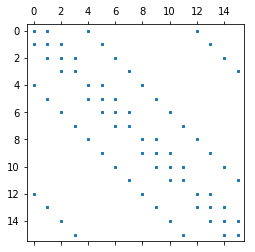

In [5]:
plt.spy(H, markersize = 2)
plt.show()

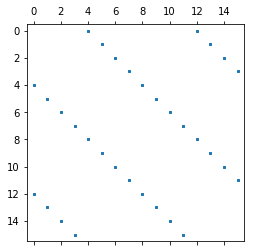

In [6]:
plt.spy(V, markersize = 2)
plt.show()

## 5. Create a random state
* In all the LSQT methods, the first crucial step is to use random vector approximation for evaluating the trace of a matrix.
* We use random phase vector, whose elements can be written as $e^{i\theta}=\cos(\theta)+i\sin(\theta)$, where $\theta$ is a random number within $[0, 2\pi]$.

### 5.1 Define the function

In [7]:
def create_state(N):
    """
    Function to construct a complex random vector
    Args:
        N (int): Length of the vector
    Returns:
        phi (complex ndarray): The random vector
    """
    random_phase = np.random.uniform(0, 2 * np.pi, N)
    phi = np.cos(random_phase) + np.sin(random_phase) * 1j; 
    phi = phi / np.linalg.norm(phi);
    return phi

### 5.2 Check the function
1. We see that the vector is complex and is correctely normalized to 1

In [8]:
phi = create_state(10)
print("phi = ")
print(phi)
print("norm(phi) = ")
print(np.linalg.norm(phi)) # should be 1

phi = 
[ 0.22447669+0.22273351j -0.31437405+0.03419003j -0.31393732-0.03799156j
  0.26724079+0.16906319j  0.27822370+0.15030494j -0.29437700+0.11550837j
 -0.07553539+0.30707394j -0.15911728-0.27327951j -0.27890111+0.14904419j
  0.26844826-0.16713926j]
norm(phi) = 
1.0


## 6. Calculate the Chebyshev moments
1. The chebyshev moments $C_m$ of the DOS, VAC, and MSD can be uniformly expresseed as
$$
C_m = \langle \phi_L| T_m(\tilde{H}) | \phi_R \rangle,
$$
where $\tilde{H}$ is the scaled Hamiltonian and $T_m$ is the $m$-th order Chebyshev polynomial of the first kind.
2. The differences between the above three quantities are reflected by the different left and right vectors, $\phi_L$ and $\phi_R$.
3. See Algorithm 4 in the review paper.

### 6.1. Define the function
* There is no simple way to test this function. So we will continue to write other functions.

In [9]:
def find_moments(M, H_scaled, phi_left, phi_right):
    """
    Calculate the Chebyshev moments
    Inputs:
        M         (int):               Number of Chebyshev moments
        phi_left  (complex ndarray):   The left vector
        phi_right (complex ndarray):   The right vector
        H_scaled  (sparse.csr_matrix): Scaled (sparse) Hamiltonian
    Outputs:
        C         (real ndarray):      The Chebyshev moments
    """   
    C = np.zeros(M)
    phi_0 = phi_right
    C[0] = np.vdot(phi_left, phi_0).real
    phi_1 = H_scaled.dot(phi_0)
    C[1] = np.vdot(phi_left, phi_1).real
    for m in range(2, M):
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        C[m] = np.vdot(phi_left, phi_2).real
        phi_0 = phi_1
        phi_1 = phi_2
    return C

## 7. Calculate the Chebyshev summation
1. The chebyshev summation gives the final results:
  * DOS: Equation (94) in the review paper
  * DOS times VAC: Equation (100) in the review paper
  * DOS times MSD: Equation (102) in the review paper

### 7.1 The damping factor
1. We only consider the Jackson damping factor.
2. One can compare the figure to that in Fig. 3 of the review paper.

In [10]:
def jackson_damping(M):
    """
    Calculate the Jackson damping factor
    Inputs:
        M (int):           Number of Chebyshev moments
    Outputs:
        g (real ndarray):  The Jackson damping factor
    """
    m = np.arange(M)
    a = 1.0 / (M + 1.0)
    g = (1.0 - m * a) * np.cos(np.pi * m * a)
    g += a * np.sin(np.pi * m * a) / np.tan(np.pi * a)
    return g

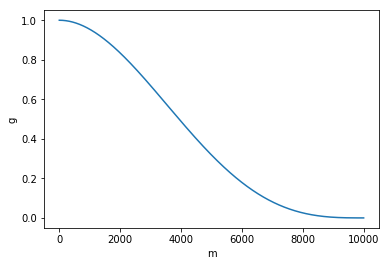

In [11]:
M = 10000
plt.plot(np.arange(M), jackson_damping(M))
plt.xlabel('m')
plt.ylabel('g')
plt.show()

### 7.2 Calculate the Chebyshev summation
1. Check Eqs. (94), (100), and (102) in the review paper.

In [12]:
def chebyshev_summation(M, C, E_scaled, E_max):
    """
    Calculate the Chebyshev summation
    Inputs:
        M        (int):          Number of Chebyshev moments
        C        (real ndarray): Chebyshev moments
        E_scaled (real ndarray): energy points
        E_max    (real):         scaling factor of energy
    Outputs:
        s        (real ndarray): Chebyshev summation
    """
    g = jackson_damping(M) # get the damping factor
    C *= g                 # apply the damping factor
    Ne = E_scaled.size     # number of energy points
    T0 = np.ones(Ne)
    T1 = E_scaled
    s = C[1] * T1
    for m in range(2, M):
        T2 = 2.0 * E_scaled * T1 - T0
        T0 = T1
        T1 = T2
        s += C[m] * T2
    s *= 2.0
    s += C[0] * np.ones(Ne)
    s *= 2.0 / (np.pi * np.sqrt(1.0 - E_scaled * E_scaled) * E_max)
    return s

## 8. Calculate the DOS

### 8.1. Define the function
1. Check Eq. (94) in the review paper.

In [13]:
def find_dos(M, E_max, E_scaled, H_scaled, phi):
    """
    Calculate the DOS (density of states)
    Inputs:
        M        (int):               Number of Chebyshev moments
        E_max    (real):              Energy scaling factor
        E_scaled (real ndarray):      Scaled energy
        H_scaled (sparse.csr_matrix): Scaled Hamiltonian
        phi      (complex adarray):   The initial random vector
    Outputs:
        DOS      (real ndarray):      The DOS
    """
    C = find_moments(M, H_scaled, phi, phi)
    DOS = chebyshev_summation(M, C, E_scaled, E_max)
    return DOS

### 8.2. Do some tests
1. We will try to get a similar plot as in Fig. 5(c) in the review paper.
2. Note that the results in the review paper were obained using the efficient GPUQT code. So there are some differences in the parameters chosen:
 * The number of sites in the review paper is 10 times larger in this example.
 * The number of moments is 3000 in the review paper, while it is 1000 here.
 * The results in the review paper were obtained by averaging over 10 random vectors, while we only use a single random vector below.
3. Therefore, the results in the review paper are more accurate.

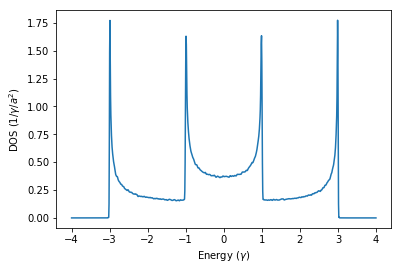

In [14]:
# (1) Prepare some parameters
Nx = 500000
Ny = 2
W = 0
E_max = 4.1
M = 1000
E = np.linspace(-4, 4, num = 1001)
# (2) Construct the model
H, V = find_H(Nx, Ny, W)
phi = create_state(Nx * Ny)
# (3) Calculate the DOS
DOS = find_dos(M, E_max, E/E_max, H/E_max, phi)
# (4) Plot the results
plt.plot(E, DOS)
plt.xlabel('Energy ($\gamma$)')
plt.ylabel('DOS ($1/\gamma/a^2$)')
plt.show()

## 9. Time evolution
1. To calculate transport properties (VAC, MSD), we need to consider time evolution
2. For the time evolution operator $\hat{U}(\pm \Delta t)$, see Eqs. (73) and (74) in the review paper.
2. For the time evolution operator $[X, \hat{U}(\Delta t)]$, see Eqs. (75) and (76) in the review paper.

### 9.1. Evaluating $|\phi_{\rm out}\rangle = \hat{U}(\pm \Delta t) |\phi_{\rm in}\rangle$
1. The implementation below follows Algorithm 1 in the review paper.
2. For the Bessel function of the first kind, we use scipy.special.jv(n, x).

In [15]:
def evolve(H_scaled, dt_scaled, sign, phi_i):
    """
    Calculate the action of the time evolution operator on a vector
    Inputs:
        H_scaled  (complex sparse.csr_matrix):  Scaled Hamiltonian
        dt_scaled (real):                       scaled time step
        sign      (int):                        1 for U(dt) and -1 for U(-dt)
        phi_i     (complex ndarray):            input vector
    Outputs:
        phi_o:    (complex ndarray):            output vector
    """
    phi_0 = phi_i
    phi_1 = H_scaled.dot(phi_i)
    j0 = special.jv(0, dt_scaled)
    j1 = special.jv(1, dt_scaled)
    phi_o = j0 * phi_0 + 2.0 * (-1j * sign) * j1 * phi_1
    m = 2
    while True:
        jm = special.jv(m, dt_scaled)
        if abs(jm) < 1.0e-15:
            break
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        phi_o += 2.0 * (-1j * sign) ** m * jm * phi_2
        phi_0 = phi_1
        phi_1 = phi_2
        m += 1
    return phi_o


### 9.2. Evaluating $|\phi_{\rm out}\rangle = [X, \hat{U}(\Delta t)] |\phi_{\rm in}\rangle$
1. The implementation below follows Algorithm 2 in the review paper.
2. For the Bessel function of the first kind, we use scipy.special.jv(n, x).

In [16]:
def evolvex(H_scaled, V, dt_scaled, phi_i):
    """
    Calculate the action of [X, U] on a vector
    Inputs:
        H_scaled  (complex sparse.csr_matrix):  Scaled Hamiltonian
        V         (complex sparse.csr_matrix):  Velocity operator
        dt_scaled (real):                       scaled time step
        phi_i     (complex ndarray):            input vector
    Outputs:
        phi_o:    (complex ndarray):            output vector
    """
    phi_0 = phi_i
    phix_0 = phi_i * 0.0
    phi_1 = H_scaled.dot(phi_0)
    phix_1 = 1j * V.dot(phi_0)
    phi_o = (-2.0j) * special.jv(1, dt_scaled) * phix_1
    m = 2
    while True:
        jm = special.jv(m, dt_scaled)
        if abs(jm) < 1.0e-15:
            break
        phi_2 = 2.0 * H_scaled.dot(phi_1) - phi_0
        phix_2 = 2.0j * V.dot(phi_1)
        phix_2 += 2.0 * H_scaled.dot(phix_1) - phix_0
        phi_o += 2.0 * (-1j) ** m * jm * phix_2
        phi_0 = phi_1 
        phi_1 = phi_2
        phix_0 = phix_1
        phix_1 = phix_2
        m += 1
    return pho_o

## 10. Calculate the conductivity from VAC

### 10.1. Define the function

In [17]:
def find_vac(M, E_max, dt_scaled, E_scaled, H_scaled, V, phi):
    """
    Calculate DOS * VAC
    Parameters
    ----------
    M:         Number of Chebyshev moments
    E_max:     Energy scaling factor
    dt_scaled: Scale time steps
    E_scaled:  Scaled energy
    H_scaled:  Scaled (sparse) Hamiltonian
    V:         The (sparse) velocity operator
    phi:       The initial random vector
    Returns
    -------
    DOS_times_VAC: DOS * VAC
    """
    Ne = E_scaled.size  # number of energy points
    Nt = dt_scaled.size # number of time steps
    phi_left = phi
    phi_right = V.dot(phi)
    DOS_times_VAC = np.zeros((Nt, Ne))
    for nt in range(Nt):
        C = find_moments(M, H, V.dot(phi_left), phi_right)
        DOS_times_VAC[nt, :] = chebyshev_summation(M, C, E, E_max)
        phi_left = evolve(H, dt[nt], -1, phi_left)
        phi_right = evolve(H, dt[nt], -1, phi_right)
    return DOS_times_VAC

## 11. Calculate the conductivity from MSD

In [18]:
def find_dos_times_msd(M, E_max, dt_scaled, E_scaled, H_scaled, V, phi):
    """
    Calculate DOS * MSD
    Parameters
    ----------
    M:         Number of Chebyshev moments
    E_max:     Energy scaling factor
    dt_scaled: Scale time steps
    E_scaled:  Scaled energy
    H_scaled:  Scaled (sparse) Hamiltonian
    V:         The (sparse) velocity operator
    phi:       The initial random vector
    Returns
    -------
    DOS_times_MSD: DOS * MSD
    """
    Ne = E_scaled.size  # number of energy points
    Nt = dt_scaled.size # number of time steps
    phix = phi * 0.0
    DOS_times_MSD = np.zeros((Nt, Ne))
    for nt in range(Nt):
        phix = evolve(H, dt[nt], 1, phix);
        phix = phix + evolvex(H, V, dt[nt], phi);
        phi = evolve(H, dt[nt], 1, phi);
        Cn = find_moments(M, H, phix, phix);
        DOS_times_MSD[nt, :] = chebyshev_summation(M, Cn, E, E_max);
    return DOS_times_MSD